In [7]:
import numpy as np
import warnings
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE


np.random.seed(42)

In [8]:
wine = pd.read_csv("~/ucare-summer2020/datasets/winequality-white.csv", sep=";")

X = wine.drop(columns=['quality'])
y = wine['quality']
y = y > 5
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler();

In [9]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X.iloc[:,0].min() - 0.01, X.iloc[:, 0].max() + 0.01
    
    # Get the min and max value of feature x2
    x2min, x2max = X.iloc[:,1].min() - 0.01, X.iloc[:, 1].max() + 0.01
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.binary, alpha=0.8)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()

In [10]:
def plot_boundary_clf(clf, X):
    plt.figure(figsize=(12, 6))

    decision_boundary_class_colored(clf, X)

    plt.plot(X[y==0].iloc[:,0], X[y==0].iloc[:,1], "bo", ms=3)
    plt.plot(X[y==1].iloc[:,0], X[y==1].iloc[:,1], "go", ms=3)
    
    bp = 99.9 #boundary percentile for axis scaling
    xmin0, xmax0 = np.percentile(X.iloc[:,0], 100-bp), np.percentile(X.iloc[:,0], bp)
    xmin1, xmax1 = np.percentile(X.iloc[:,1], 100-bp), np.percentile(X.iloc[:,1], bp)
    plt.axis([xmin0, xmax0, xmin1, xmax1])
    plt.annotate('Bad Wine', xy=(0.85, 0.95), xycoords='axes fraction', color="b")
    plt.annotate('Good Wine', xy=(0.85, 0.85), xycoords='axes fraction', color="g")
    plt.xlabel("Feature 1", fontsize=14)
    plt.ylabel("Feature 2", fontsize=14)
    plt.title("SVM Decision Boundary Plot", fontsize=16)
    plt.show()

In [11]:
def report_clf(clf, X_train, X_test):
    y_train_predicted = clf.predict(X_train)
    y_test_predicted = clf.predict(X_test)
    print("\nTrain Accuracy: ", np.mean(y_train_predicted == y_train))
    print("-----------------------------------------")
    print("\nTest Accuracy: ", np.mean(y_test_predicted == y_test))
    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_predicted))


    precision_test = precision_score(y_test, y_test_predicted) 
    print("\nTest Precision = %f" % precision_test)

    recall_test = recall_score(y_test, y_test_predicted)
    print("Test Recall = %f" % recall_test)


    f1_test = f1_score(y_test, y_test_predicted)
    print("Test F1 Score = %f" % f1_test)


    print("\nClassification Report:")
    print(classification_report(y_test, y_test_predicted))

In [24]:
def run_SVM_TSNE(C, gamma, components, perplexity, plot=False):

    print("SVM grid search with %i components and perplexity of %i" % (components, perplexity))
    param_grid = {'svc__kernel': ['rbf'], 'svc__max_iter': [5000],
                     'svc__C': C, 'svc__gamma': gamma}
    svm_clf = SVC()
    tsne = TSNE(n_components=components, perplexity=perplexity)
    
    X_tsne = tsne.fit_transform(X)
    X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(X_tsne, y, test_size=0.20, random_state=42)

    tsne_clf = Pipeline([
        ("scaler", scaler),
        ("svc", svm_clf)
    ])
    tsne_clf_cv = GridSearchCV(tsne_clf, param_grid, scoring='accuracy',
                            cv=3, verbose=1, n_jobs=-1)
    
    tsne_clf_cv.fit(X_train_tsne, y_train_tsne)
    params_optimal = tsne_clf_cv.best_params_
    print("Optimal Hyperparameter Values: ", params_optimal)
    print("\n")
    
    clf = tsne_clf_cv
    report_clf(clf, X_train_tsne, X_test_tsne)
    
    if(plot == True):
        X_tsne = pd.DataFrame(X_tsne)
        plot_boundary_clf(clf, X_tsne)

CPU times: user 56.6 s, sys: 726 ms, total: 57.3 s
Wall time: 15.7 s
CPU times: user 59.9 s, sys: 700 ms, total: 1min
Wall time: 15.6 s
CPU times: user 1min 28s, sys: 986 ms, total: 1min 29s
Wall time: 23 s
CPU times: user 1min 50s, sys: 1.75 s, total: 1min 52s
Wall time: 29.4 s
CPU times: user 2min 34s, sys: 2.19 s, total: 2min 36s
Wall time: 41.1 s
CPU times: user 3min 12s, sys: 4.64 s, total: 3min 17s
Wall time: 1min 4s
CPU times: user 4min 22s, sys: 6.12 s, total: 4min 28s
Wall time: 1min 31s
CPU times: user 4min 40s, sys: 6.64 s, total: 4min 46s
Wall time: 1min 30s
CPU times: user 6min 16s, sys: 9.27 s, total: 6min 25s
Wall time: 2min 5s


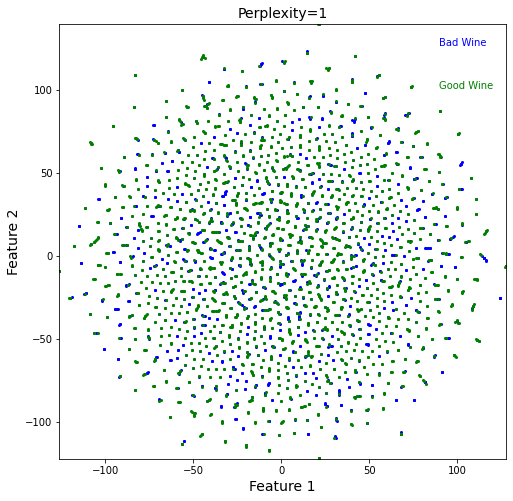

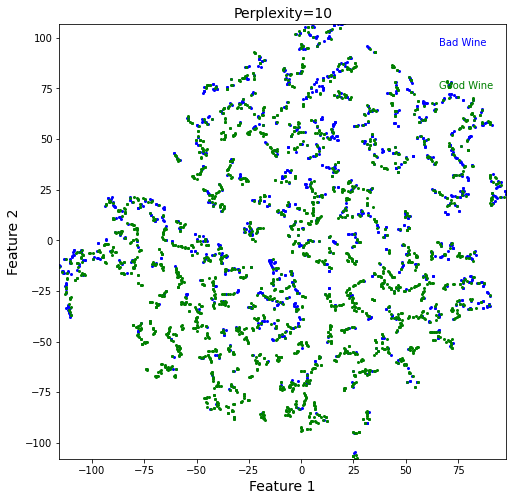

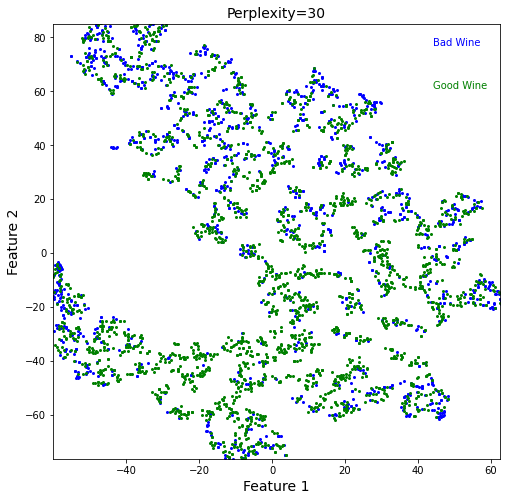

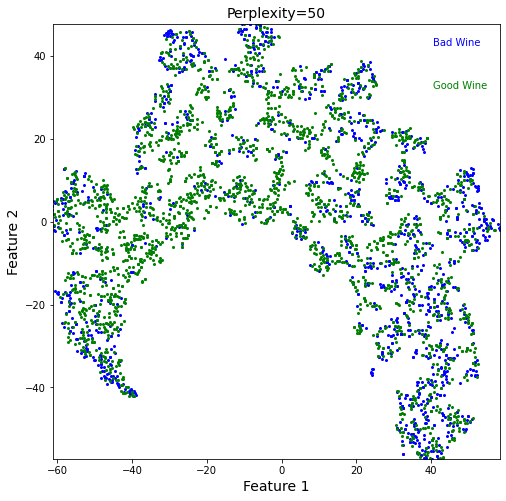

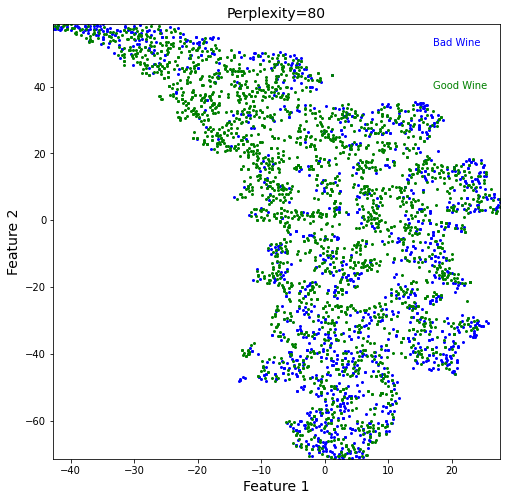

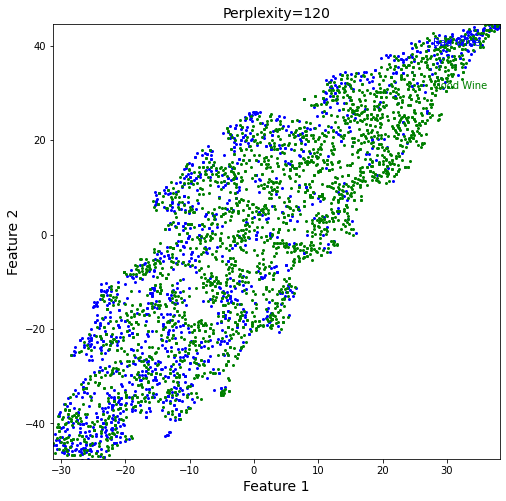

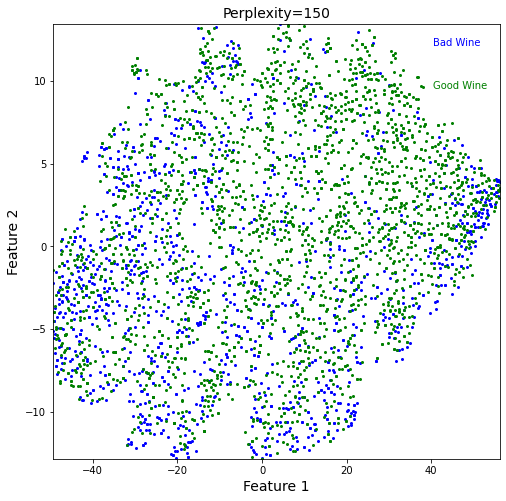

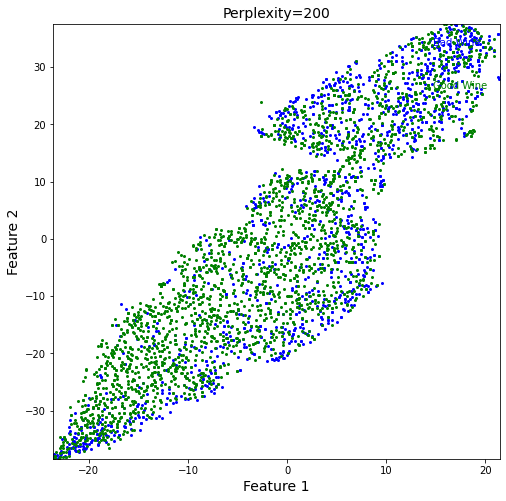

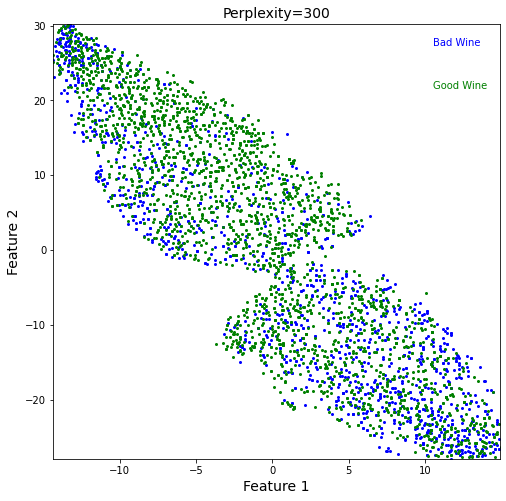

In [24]:
for i in [1, 10, 30, 50, 80, 120, 150, 200, 300]:   
    tsne = TSNE(n_components=2, perplexity=i)
    %time X_tsne = tsne.fit_transform(X_train)
    X_tsne = pd.DataFrame(X_tsne, index=X_train.index)
    
    plt.figure(figsize=(8,8))

    plt.plot(X_tsne[y_train==0].iloc[:,0], X_tsne[y_train==0].iloc[:,1], "bo", ms=2)
    plt.plot(X_tsne[y_train==1].iloc[:,0], X_tsne[y_train==1].iloc[:,1], "go", ms=2)

    bp = 99.9 #boundary percentile for axis scaling
    xmin0, xmax0 = np.percentile(X_tsne.iloc[:,0], 100-bp), np.percentile(X_tsne.iloc[:,0], bp)
    xmin1, xmax1 = np.percentile(X_tsne.iloc[:,1], 100-bp), np.percentile(X_tsne.iloc[:,1], bp)
    plt.axis([xmin0, xmax0, xmin1, xmax1])
    plt.annotate('Bad Wine', xy=(0.85, 0.95), xycoords='axes fraction', color="b")
    plt.annotate('Good Wine', xy=(0.85, 0.85), xycoords='axes fraction', color="g")
    plt.xlabel("Feature 1", fontsize=14)
    plt.ylabel("Feature 2", fontsize=14)
    plt.title("Perplexity=%d" % i, fontsize=14)

SVM grid search with 2 components and perplexity of 10
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.3s finished
/Users/eyloncaplan/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Optimal Hyperparameter Values:  {'svc__C': 1000, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 5000}



Train Accuracy:  0.9961715160796325
-----------------------------------------

Test Accuracy:  0.7397959183673469

Test Confusion Matrix:
[[191 130]
 [125 534]]

Test Precision = 0.804217
Test Recall = 0.810319
Test F1 Score = 0.807256

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       321
           1       0.80      0.81      0.81       659

    accuracy                           0.74       980
   macro avg       0.70      0.70      0.70       980
weighted avg       0.74      0.74      0.74       980



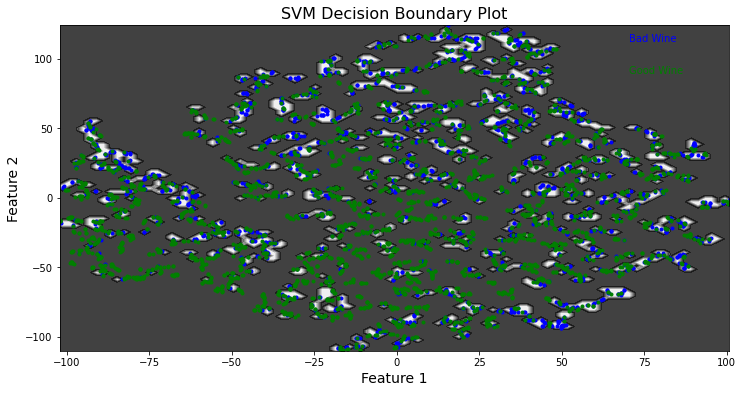

SVM grid search with 2 components and perplexity of 30
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.2s finished


Optimal Hyperparameter Values:  {'svc__C': 1, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 5000}



Train Accuracy:  0.8700867789688617
-----------------------------------------

Test Accuracy:  0.736734693877551

Test Confusion Matrix:
[[140 181]
 [ 77 582]]

Test Precision = 0.762779
Test Recall = 0.883156
Test F1 Score = 0.818565

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.44      0.52       321
           1       0.76      0.88      0.82       659

    accuracy                           0.74       980
   macro avg       0.70      0.66      0.67       980
weighted avg       0.72      0.74      0.72       980



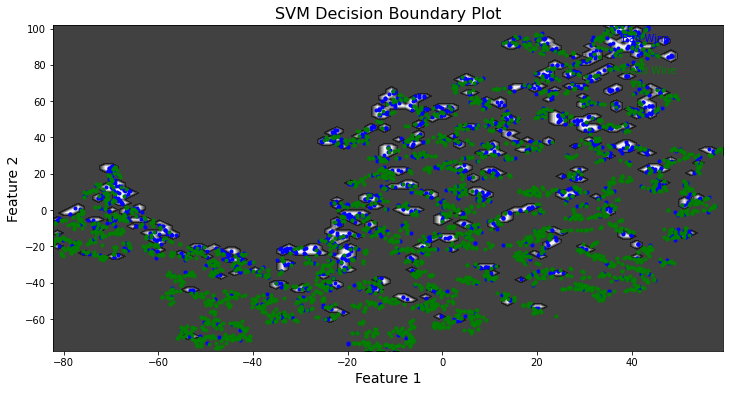

SVM grid search with 2 components and perplexity of 50
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.1s finished


Optimal Hyperparameter Values:  {'svc__C': 1, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 5000}



Train Accuracy:  0.8846350178662583
-----------------------------------------

Test Accuracy:  0.746938775510204

Test Confusion Matrix:
[[142 179]
 [ 69 590]]

Test Precision = 0.767230
Test Recall = 0.895296
Test F1 Score = 0.826331

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.44      0.53       321
           1       0.77      0.90      0.83       659

    accuracy                           0.75       980
   macro avg       0.72      0.67      0.68       980
weighted avg       0.74      0.75      0.73       980



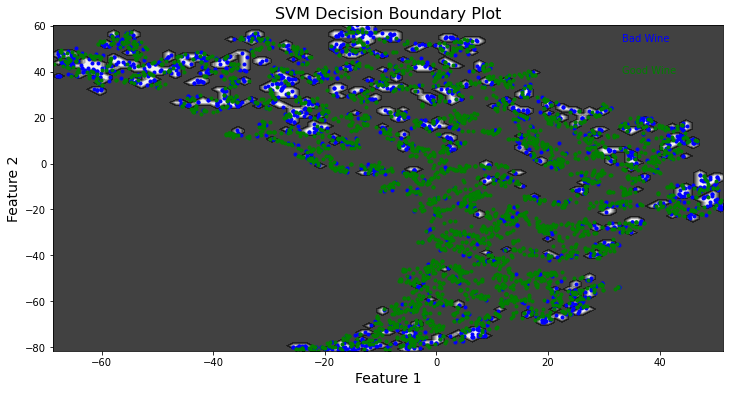

SVM grid search with 2 components and perplexity of 80
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   11.9s finished
/Users/eyloncaplan/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Optimal Hyperparameter Values:  {'svc__C': 1, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 5000}



Train Accuracy:  0.9040326697294538
-----------------------------------------

Test Accuracy:  0.7438775510204082

Test Confusion Matrix:
[[130 191]
 [ 60 599]]

Test Precision = 0.758228
Test Recall = 0.908953
Test F1 Score = 0.826777

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.40      0.51       321
           1       0.76      0.91      0.83       659

    accuracy                           0.74       980
   macro avg       0.72      0.66      0.67       980
weighted avg       0.73      0.74      0.72       980



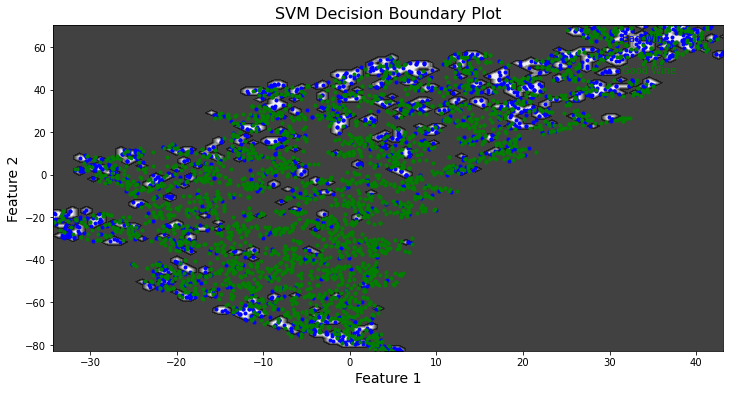

SVM grid search with 2 components and perplexity of 120
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   11.8s finished


Optimal Hyperparameter Values:  {'svc__C': 1, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 5000}



Train Accuracy:  0.9400204185809087
-----------------------------------------

Test Accuracy:  0.7489795918367347

Test Confusion Matrix:
[[131 190]
 [ 56 603]]

Test Precision = 0.760404
Test Recall = 0.915023
Test F1 Score = 0.830579

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.41      0.52       321
           1       0.76      0.92      0.83       659

    accuracy                           0.75       980
   macro avg       0.73      0.66      0.67       980
weighted avg       0.74      0.75      0.73       980



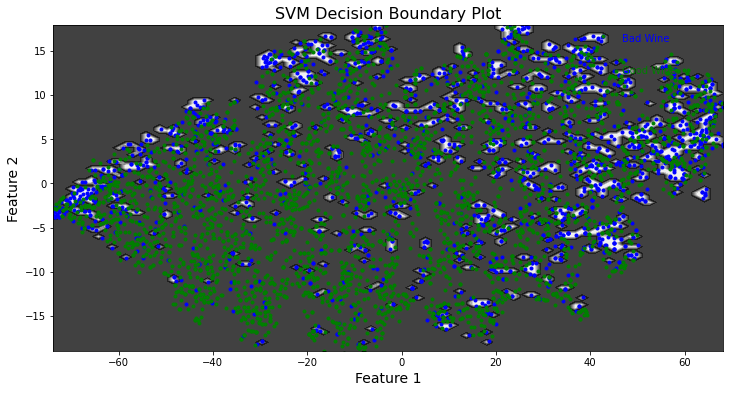

SVM grid search with 2 components and perplexity of 200
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   21.2s finished
/Users/eyloncaplan/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Optimal Hyperparameter Values:  {'svc__C': 1000, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 5000}



Train Accuracy:  0.9989790709545686
-----------------------------------------

Test Accuracy:  0.7346938775510204

Test Confusion Matrix:
[[161 160]
 [100 559]]

Test Precision = 0.777469
Test Recall = 0.848255
Test F1 Score = 0.811321

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.50      0.55       321
           1       0.78      0.85      0.81       659

    accuracy                           0.73       980
   macro avg       0.70      0.67      0.68       980
weighted avg       0.72      0.73      0.73       980



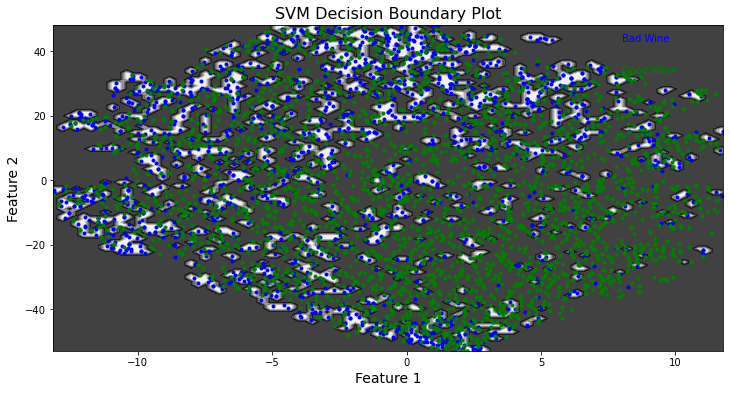

In [33]:
C = [0.001, 0.01, 1, 10, 1000]
gamma = [0.0001, 0.01, 1, 10, 100, 1000]
for p in [10, 30, 50, 80, 120, 200]:   
    run_SVM_TSNE(C, gamma, 2, p, plot=True)

In [32]:
C = [0.001, 0.01, 1, 10, 1000]
gamma = [0.0001, 0.01, 1, 10, 100, 1000]
for p in [10, 30, 50, 80, 120, 200]:  
    run_SVM_TSNE(C, gamma, 3, p)

SVM grid search with 3 components and perplexity of 10
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   16.7s finished
/Users/eyloncaplan/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Optimal Hyperparameter Values:  {'svc__C': 1, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 5000}



Train Accuracy:  0.9571209800918836
-----------------------------------------

Test Accuracy:  0.7581632653061224

Test Confusion Matrix:
[[127 194]
 [ 43 616]]

Test Precision = 0.760494
Test Recall = 0.934750
Test F1 Score = 0.838666

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.40      0.52       321
           1       0.76      0.93      0.84       659

    accuracy                           0.76       980
   macro avg       0.75      0.67      0.68       980
weighted avg       0.76      0.76      0.73       980

SVM grid search with 3 components and perplexity of 30
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.3s finished
/Users/eyloncaplan/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Optimal Hyperparameter Values:  {'svc__C': 1, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 5000}



Train Accuracy:  0.9711587544665645
-----------------------------------------

Test Accuracy:  0.7520408163265306

Test Confusion Matrix:
[[113 208]
 [ 35 624]]

Test Precision = 0.750000
Test Recall = 0.946889
Test F1 Score = 0.837022

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.35      0.48       321
           1       0.75      0.95      0.84       659

    accuracy                           0.75       980
   macro avg       0.76      0.65      0.66       980
weighted avg       0.75      0.75      0.72       980

SVM grid search with 3 components and perplexity of 50
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.4s finished
/Users/eyloncaplan/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Optimal Hyperparameter Values:  {'svc__C': 1, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 5000}



Train Accuracy:  0.9747320061255743
-----------------------------------------

Test Accuracy:  0.7551020408163265

Test Confusion Matrix:
[[108 213]
 [ 27 632]]

Test Precision = 0.747929
Test Recall = 0.959029
Test F1 Score = 0.840426

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.34      0.47       321
           1       0.75      0.96      0.84       659

    accuracy                           0.76       980
   macro avg       0.77      0.65      0.66       980
weighted avg       0.76      0.76      0.72       980

SVM grid search with 3 components and perplexity of 80
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.3s finished
/Users/eyloncaplan/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Optimal Hyperparameter Values:  {'svc__C': 1000, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 5000}



Train Accuracy:  0.9994895354772844
-----------------------------------------

Test Accuracy:  0.7653061224489796

Test Confusion Matrix:
[[125 196]
 [ 34 625]]

Test Precision = 0.761267
Test Recall = 0.948407
Test F1 Score = 0.844595

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.39      0.52       321
           1       0.76      0.95      0.84       659

    accuracy                           0.77       980
   macro avg       0.77      0.67      0.68       980
weighted avg       0.77      0.77      0.74       980

SVM grid search with 3 components and perplexity of 120
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.6s finished
/Users/eyloncaplan/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Optimal Hyperparameter Values:  {'svc__C': 1000, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 5000}



Train Accuracy:  0.9994895354772844
-----------------------------------------

Test Accuracy:  0.7642857142857142

Test Confusion Matrix:
[[125 196]
 [ 35 624]]

Test Precision = 0.760976
Test Recall = 0.946889
Test F1 Score = 0.843813

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.39      0.52       321
           1       0.76      0.95      0.84       659

    accuracy                           0.76       980
   macro avg       0.77      0.67      0.68       980
weighted avg       0.77      0.76      0.74       980

SVM grid search with 3 components and perplexity of 200
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.9s finished
/Users/eyloncaplan/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Optimal Hyperparameter Values:  {'svc__C': 1000, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 5000}



Train Accuracy:  0.9992343032159265
-----------------------------------------

Test Accuracy:  0.7693877551020408

Test Confusion Matrix:
[[120 201]
 [ 25 634]]

Test Precision = 0.759281
Test Recall = 0.962064
Test F1 Score = 0.848728

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.37      0.52       321
           1       0.76      0.96      0.85       659

    accuracy                           0.77       980
   macro avg       0.79      0.67      0.68       980
weighted avg       0.78      0.77      0.74       980

